<a href="https://colab.research.google.com/github/RSNA/MagiciansCorner/blob/master/MedNISTClassify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classify the type of radiological image using the MedNIST collection

*by: Bradley J Erickson, MD PhD*
*Copyright 2019*

In this tutorial we will:
1) download and unzip 3 different classes of radiological images (CT Head, CT Chest, CT Abdomen). 
2) We will use a Convolutional Neural Network (CNN) pretrained on routine photgraphic images and using the ResNet 34 architecture to classify each of the 3 types of images
3) We will review the performance of the system, note the 'worst' errors, and consider how we might improve performance


In [1]:
#Cell 1
# first, need to install and then import the fastai library
!pip3 install fastai
from fastai.vision import *

In [2]:
#Cell 2
# clean out any old data just to be sure, such as if re-running cells
!rm -rf MagiciansCorner
!rm -rf images

!git clone https://github.com/RSNA/MagiciansCorner.git
!mkdir images
!cd images; unzip -q "../MagiciansCorner/MedNIST.zip" 
!rm -rf MagiciansCorner
# get rid of MAC garbage stuff
!rm -rf ./images/__MACOSX
!ls images


Cloning into 'MagiciansCorner'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.
CTAbd  CTChest	CTHead	CXR  MRBrain  MRBreast


In [3]:
#Cell 3
classes_dir = "./images"
flist = os.listdir(classes_dir)
print (flist)

['MRBreast', 'CTChest', 'CXR', 'CTHead', 'CTAbd', 'MRBrain']


### We have already gone through and converted the DICOM images to JPEG (grayscale) images, and also sized so they are all 64x64 (if we kept CXRs as some size other than 64x64, it would cause the CNN to fail--all image MUST be the same size. The next article will explain more about this.



## View data

In [4]:
#Cell 4
np.random.seed(42)
data = ImageDataBunch.from_folder(classes_dir, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=64, num_workers=4).normalize(imagenet_stats)
data.classes
data.classes, data.c, len(data.train_ds), len(data.valid_ds)


(['CTAbd', 'CTChest', 'CTHead', 'CXR', 'MRBrain', 'MRBreast'], 6, 1440, 360)

Good! Let's take a look at some of our pictures then.

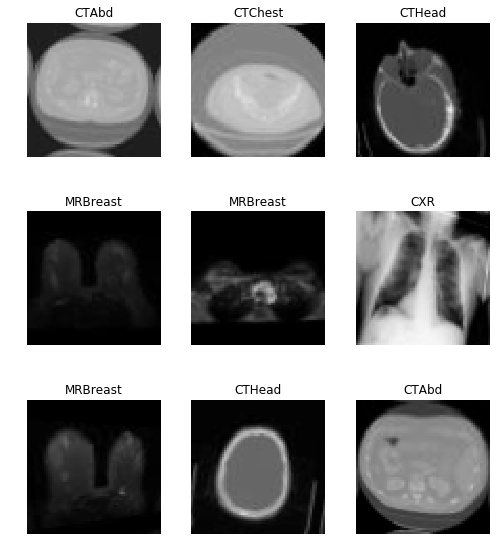

In [5]:
#Cell 5
data.show_batch(rows=3, figsize=(7,8))

## Train model

In [6]:
#Cell 6
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
#learn = cnn_learner(data, models.resnet50, metrics=error_rate)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 102656308.68it/s]


In [7]:
#Cell 7
learn.fit_one_cycle(3)
learn.save("MedNIST-34-1")

epoch,train_loss,valid_loss,error_rate,time
0,1.006247,0.436367,0.158333,00:05
1,0.491103,0.160342,0.050000,00:04
2,0.309581,0.063073,0.016667,00:04


#Evaluation
* During the training process, the data is split into 3 parts: training, testing and validation. The training data is used to adjust the weights. The GPU does not have enough RAM to store the entire training set of images, so it is split into 'batches'. When all of the images have been used once for training, then an 'epoch' has passed. Once trained for that epoch, it evaluates how well it has learned using the 'test' data set. The performance on the training set is the train_loss and the performance on the validation set is the valid_loss, and the error_rate is also the percentage of cases wrong in the validation set.
* It is common practice that after 'acceptable' performance is achieved on the vclidation set, that the system is tested on the 'test' data, and that is what is considered the 'real' performance.
* Note that some use 'test' for what is called validation here, and vice versa.

* But sometimes the overall error rate doesn't really tell the story. We might care more about false positives than false negatives, and vica versa. Looking at early results can provide valuable insight into the training process, and how to improve results.

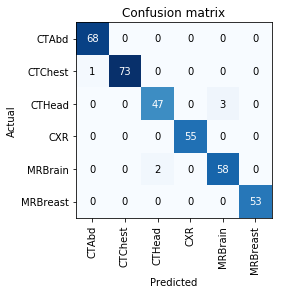

In [8]:
#Cell 8
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Looking closer
* The confusion matrix shows that there is more confusion between chests and abdomens than with heads. Does that surprise you?
* Lets look a little closer at those. FastAI has a nice function that can show you the cases the it did the worst on. Think about that--there are 'errors' but what are the worst errors?
* Well, the class assigned to an image is the class that gets the highest score. So the 'worst' would be those where the score for the correct class was lowest. The function 'plot_top_losses' will show the predicted class, the real class, and the score, as well as the image for the N 
(in our case, 9) worst scored cases.
* The second line of code in the cell shows another nice feature of FastAI: to get documentation on any function, just type 'doc(function)' and it will print the documentation for that function. AND it also has a link you can click to then see teh actual source code that implements that function.

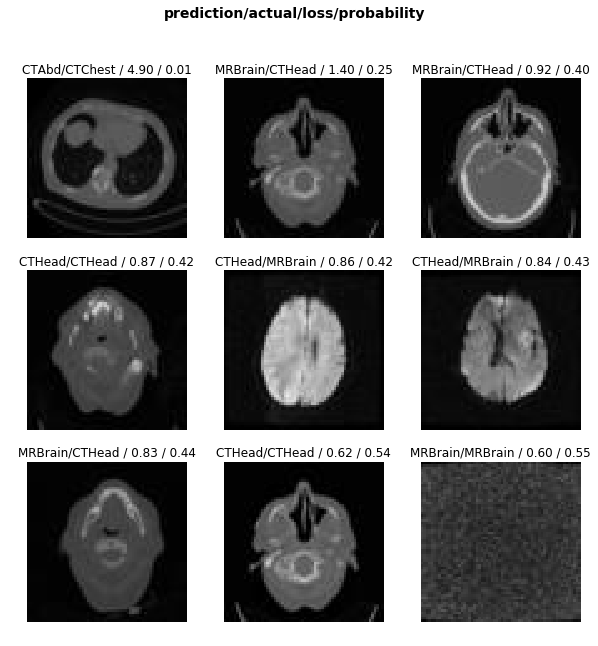

In [9]:
#Cell 9
interp.plot_top_losses(9, figsize=(10,10))
doc(interp.plot_top_losses)

# What do we see?
* Most of the errant classes are slices that contain BOTH lung and abdomen. 
* This is an important point: Data preparation and curation is critical to getting good results
* We can argue about how to handle these cases. The correct answer probably depends on your use case. The point is that without seeing these error cases, fyou might never know what was going wrong...


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


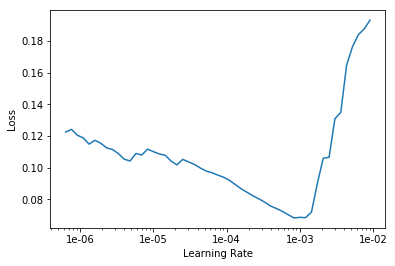

In [10]:
#Cell 10
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()


# Extra credit:
* We 'cheated' by starting with a network that was already trained on more than 1,000,000 images. That means the system really only had to learn the specific features of these body parts, but the lower level features like edges and lines were already 'known' to be important to the network.
* On the other hand, the 'pretrained' network was trained on photographic images, which are color, not gray scale, and had a matrix size other than 64x64. 
* While we could start from scratch, a better option might be to use the pre-trained values, but allow any of the weights and kernels in the network to be changed, and that is what 'unfreeze' does. 

In [11]:
#Cell 1
learn.fit_one_cycle(5, max_lr=slice(3e-6,3e-5))
learn.save("Unfreeze-34-1")

epoch,train_loss,valid_loss,error_rate,time
0,0.103533,0.050715,0.008333,00:04
1,0.094620,0.036167,0.005556,00:04
2,0.082101,0.028545,0.002778,00:04
3,0.070466,0.026003,0.002778,00:04
4,0.065995,0.026027,0.002778,00:04
